In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from epoxide_ketone_kinectic import plot_cyclopentene
from epoxide_ketone_kinectic import plot_water_activity


plt.style.use("/Users/chenyujiang/Python/manthiram-mpl-defaults.mplstyle")

rcParams["axes.titleweight"] = "bold"
c_e = "#084191"
c_k = "#EF476F"
c_a = "#ffc857"
c_1 = "#FFD166"
c_2 = "#F72585"
c_3 = "#7209B7"
c_4 = "#3A0CA3"
c_5 = "#4361EE"
c_6 = "#4CC9F0"
error_kw = {"elinewidth": 2, "capsize": 5, "ecolor": "#abc4ff95"}

# Import File

In [3]:
fname = "/Users/chenyujiang/Python/kinetics/cyclopentene.xlsx"
df= pd.read_excel(fname)
#drop the row from df where exp iD is CJ_OO_323
#rename Exp iD column to exp_iD
df = df.rename(columns={"Exp iD": "exp_iD"})
df_init = df[df.exp_iD != 'CJ_OO_320']
df_init.head()

,Date,exp_iD,catalyst,conc_cyclopentene,activity_water,potential,Total_Current,FE_epoxide,FE_ketone,j_epoxide,j_ketone
0,2024-05-21,CJ_OO_294,MnO-0131,0.5,0.17,1.45,20.350020,1.583539,11.038975,0.322251,2.246434
1,2024-05-21,CJ_OO_297,MnO-0131,0.5,0.17,1.25,4.487525,8.489585,18.345374,0.380972,0.823253
2,2024-05-21,CJ_OO_298,MnO-0131,0.5,0.56,1.45,25.279541,14.546557,21.451294,3.677303,5.422789
3,2024-05-22,CJ_OO_301,MnO-0131,0.5,0.56,1.25,8.591065,7.425771,8.511267,0.637953,0.731209
4,2024-05-21,CJ_OO_295,Ir-MnO-0131,0.5,0.17,1.45,26.111024,14.168024,13.991543,3.699416,3.653335


# Grouped Stacked Plot

## Setup the data to group based on two conditions

### Define the grouping conditions

In [15]:
# Filter the data
df = df_init.loc[
    (df_init["catalyst"] == "Ir-MnO-0131") & (df_init["conc_cyclopentene"] == 0.1)
]
#display(df)

### Pivoting the data

In [16]:
# Aggregate the data to calculate mean and standard deviation
agg_df = (
    df.groupby(["activity_water", "potential"])
    .agg(
        {
            "FE_epoxide": ["mean", "std"],
            "FE_ketone": ["mean", "std"],
            "j_epoxide": ["mean", "std"],
            "j_ketone": ["mean", "std"],
        }
    )
    .reset_index()
)

# Flatten the MultiIndex columns
agg_df.columns = [
    "_".join(col).strip() if col[1] else col[0] for col in agg_df.columns.values
]

# Pivot the data for mean values
pivot_df = agg_df.pivot(
    index="activity_water",
    columns="potential",
    values=["FE_epoxide_mean", "FE_ketone_mean", "j_epoxide_mean", "j_ketone_mean"],
)
pivot_df.columns = [
    "_".join(map(str, col)).strip() for col in pivot_df.columns.values
]
pivot_df = pivot_df.reset_index()

# Pivot the data for standard deviation values (errors)
error_df = agg_df.pivot(
    index="activity_water",
    columns="potential",
    values=["FE_epoxide_std", "FE_ketone_std", "j_epoxide_std", "j_ketone_std"],
)
error_df.columns = [
    "_".join(map(str, col)).strip() for col in error_df.columns.values
]
error_df = error_df.reset_index()
#display (pivot_df)

## Ploting the Data

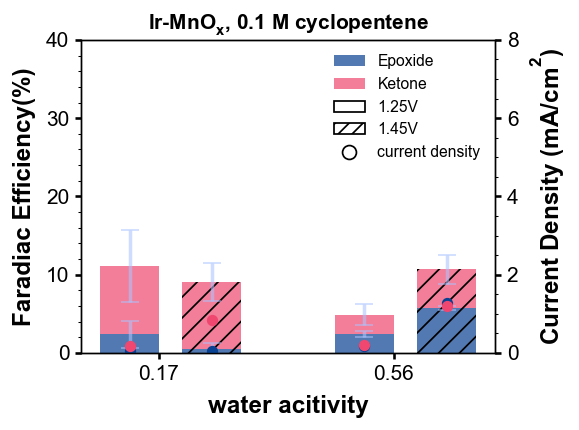

In [17]:
# Define the positions for the groups
bar_width = 0.25
bar_space = 0.1
r1 = np.arange(len(pivot_df))
r2 = [x + bar_width + bar_space for x in r1]

# Plotting
fig, ax = plt.subplots()

# Bars for Value1
ax.bar(r1, pivot_df["FE_epoxide_mean_1.25"], yerr = error_df["FE_epoxide_std_1.25"],color=c_e, width=bar_width, alpha=0.7,  error_kw=error_kw)
ax.bar(
    r1,
    pivot_df["FE_ketone_mean_1.25"],
    bottom=pivot_df["FE_epoxide_mean_1.25"],
    yerr=error_df["FE_ketone_std_1.25"],
    color=c_k,
    width=bar_width,
    alpha=0.7,
    error_kw=error_kw
)

ax.bar(
    r2, pivot_df["FE_epoxide_mean_1.45"], yerr = error_df['FE_epoxide_std_1.45'],color=c_e, width=bar_width, hatch="//", alpha=0.7,  error_kw=error_kw
)
ax.bar(
    r2,
    pivot_df["FE_ketone_mean_1.45"],
    bottom=pivot_df["FE_epoxide_mean_1.45"],
    yerr = error_df['FE_ketone_std_1.45'],
    color=c_k,
    width=bar_width,
    hatch="//",
    alpha=0.7,
    error_kw=error_kw
)

ax1 = ax.twinx()
ax1.scatter(r1, pivot_df["j_epoxide_mean_1.25"], marker=".", c=c_e)
ax1.scatter(r1, pivot_df["j_ketone_mean_1.25"], marker=".", c=c_k)
ax1.scatter(r2, pivot_df["j_epoxide_mean_1.45"], marker=".", c=c_e)
ax1.scatter(r2, pivot_df["j_ketone_mean_1.45"], marker=".", c=c_k)

# Adding labels
ax.set_title("Ir-MnO$_x$, 0.1 M cyclopentene")
ax.set_xlabel("water acitivity", fontweight="bold")
ax.set_ylabel("Faradiac Efficiency(%)", fontweight="bold")
ax.set_xticks([r + bar_width / 2 for r in range(len(pivot_df))])
ax.set_xticklabels(pivot_df["activity_water"])
ax.set_ylim(0, 40)
ax1.set_ylabel("Current Density (mA/$cm^2$)")
ax1.set_ylim(0, 8)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor=c_e, label="Epoxide", alpha=0.7),
    Patch(facecolor=c_k, label="Ketone", alpha=0.7),
    Patch(facecolor="w", edgecolor="k", label="1.25V"),
    Patch(facecolor="w", edgecolor="k", label="1.45V", hatch="///")
]
#include circle as a legend element
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='current density', markeredgecolor='k', markersize=8))
# Adding the legend
ax.legend(handles=legend_elements, loc="best")

# add the minor ticks for the y-axis for both ax and ax1
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout()

plt.show()

# Scatter and Bar Plots

## Cyclopentene Dependency

### function(plot_cyclopentene) for cyclopentene concentration

In [64]:
# write a function to generate the above plot for any potential and activity_water and cyclopentene concentration
def plot_cyclopentene(df, potential, activity_water):
    df_cyclopentene = (
        df.loc[
            (df["potential"] == potential)
            & (df["catalyst"] == "MnO-0131")
            & (df["activity_water"] == activity_water)
        ]
        .groupby(["conc_cyclopentene", "catalyst"])
        .agg(
            {
                "Total_Current": ["mean", "std"],
                "FE_epoxide": ["mean", "std"],
                "FE_ketone": ["mean", "std"],
                "j_epoxide": ["mean", "std"],
                "j_ketone": ["mean", "std"],
            }
        )
        .reset_index()
    )
    fig, ax = plt.subplots()

    ax.errorbar(
        df_cyclopentene["conc_cyclopentene"],
        df_cyclopentene["j_epoxide"]["mean"],
        yerr=df_cyclopentene["j_epoxide"]["std"],
        fmt=".",
        label="Epoxide",
        c=c_e,
        markersize=15,
    )
    ax.errorbar(
        df_cyclopentene["conc_cyclopentene"],
        df_cyclopentene["j_ketone"]["mean"],
        yerr=df_cyclopentene["j_ketone"]["std"],
        fmt=".",
        label="Ketone",
        c=c_k,
        markersize=15,
    )
    ax.set_ylabel("Current Density (mA/$cm^2$)", fontweight="bold")
    ax.set_xlabel("Cyclopentene Concentration (M)", fontweight="bold")
    ax.set_title(f"{potential} V vs.Fc/Fc$^+$, a$_w$ = {activity_water}")
    ax.set_ylim(0, 10)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(loc="upper left")
    ax.set_box_aspect(0.8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))

    return ax


In [ ]:
df_cyclopentene = (
        df_init.loc[
            (df["potential"] == 1.45)
            & (df["catalyst"] == "MnO-0131")
            & (df["activity_water"] == 0.56)
        ]
    )



fig, ax = plt.subplots()
 
#generate a scatter plot with error bar and y axis in log scale
ax.errorbar(
        df_cyclopentene["conc_cyclopentene"],
        df_cyclopentene["j_epoxide"],
        
        fmt=".",
        label="Epoxide",
        c=c_e,
        markersize=15,
    )


# Your existing plotting code here

# Set y-axis to log scale
ax.set_yscale("log")

# Set y-ticks at positions for 1 through 10
ax.set_yticks(np.arange(1, 11))

# Optionally, set custom labels for each tick (in this case, it's the same as the tick values)
#set custome lables for each tick 
ax.set_yticklabels(np.arange(1, 11))

display(df_cyclopentene)

### Calling plot_cyclopentene for plotting

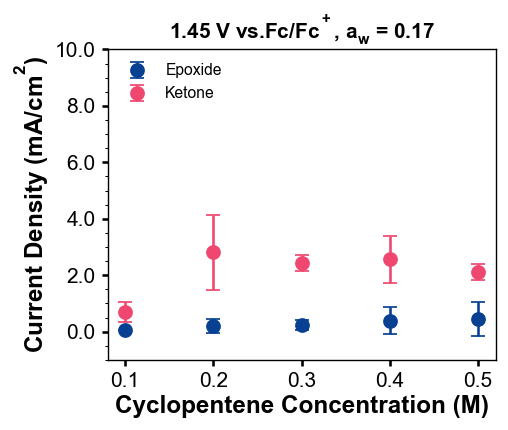

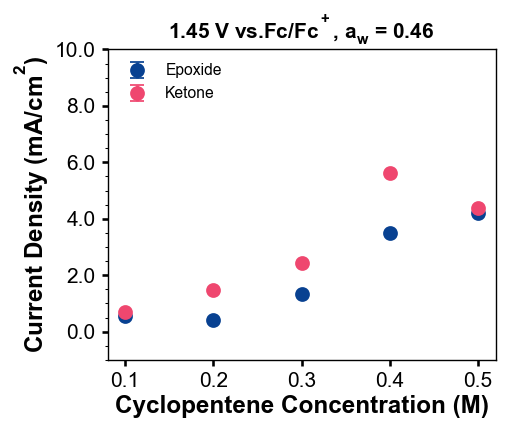

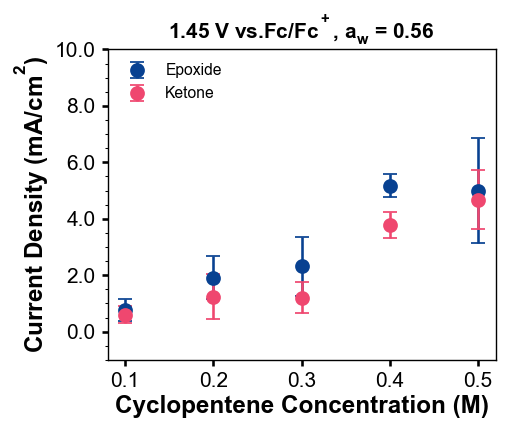

In [58]:
from epoxide_ketone_kinectic import plot_cyclopentene
ax = plot_cyclopentene(df_init, 1.45, 0.17)
#set yaxis in log scale
'''ax.set_ylim(0.1, 10)
ax.set_yscale('log')
ax.set_yticks(np.arange(1, 10,2))
ax.set_yticklabels(np.arange(1, 10,2))'''
ax1 = plot_cyclopentene(df_init, 1.45, 0.46)

ax2 = plot_cyclopentene(df_init, 1.45, 0.56)



## Water Activity

### function(plot_water_activity) for water activity

In [61]:
# generate the similar function but for water activity
def plot_water_activity(df, potential, conc_cyclopentene):
    df_water_activity = (
        df.loc[
            (df["potential"] == potential)
            & (df["catalyst"] == "MnO-0131")
            & (df["conc_cyclopentene"] == conc_cyclopentene)
        ]
        .groupby(["activity_water", "catalyst"])
        .agg(
            {
                "Total_Current": ["mean", "std"],
                "FE_epoxide": ["mean", "std"],
                "FE_ketone": ["mean", "std"],
                "j_epoxide": ["mean", "std"],
                "j_ketone": ["mean", "std"],
            }
        )
        .reset_index()
    )
    fig, ax = plt.subplots()
    ax.errorbar(
        df_water_activity["activity_water"],
        df_water_activity["j_epoxide"]["mean"],
        yerr=df_water_activity["j_epoxide"]["std"],
        fmt=".",
        label="Epoxide",
        c=c_e,markersize=15
    )
    ax.errorbar(
        df_water_activity["activity_water"],
        df_water_activity["j_ketone"]["mean"],
        yerr=df_water_activity["j_ketone"]['std'],
        fmt=".",
        label="Ketone",
        c=c_k,markersize=15
    )
    ax.set_ylabel("Current Density (mA/$cm^2$)", fontweight="bold")
    ax.set_xlabel("Water Activity", fontweight="bold")
    ax.set_title(f"{potential} V vs.Fc/Fc$^+$, {conc_cyclopentene} M cyclopentene")
    ax.set_ylim(0, 8)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend (loc = "upper left")
    ax.set_box_aspect(0.8)
    #set y-axis tick label to have one decimal point
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
    return ax


### Calling the plot_water_activity for plotting

(-0.2, 8.0)

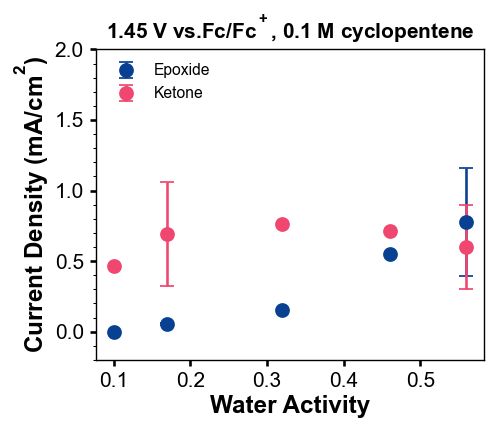

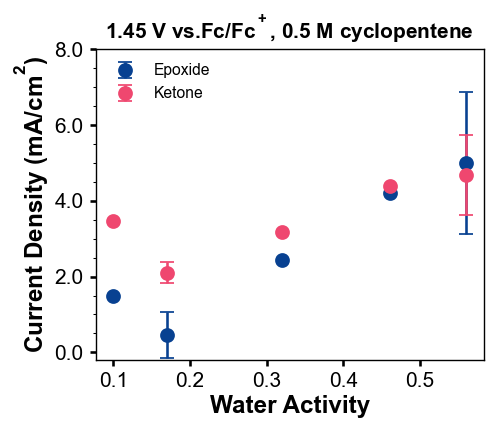

In [64]:
ax = plot_water_activity(df_init, 1.45, 0.1)
#set the y-axis limit to 2
ax.set_ylim(-0.2, 2)
ax1 = plot_water_activity(df_init, 1.45, 0.5)
ax1.set_ylim(-0.2, 8)


## Potential

### functional(plot_potential) for tafel plots

In [165]:
# generate the similar function but for potential
def plot_potential(df, activity_water, conc_cyclopentene):
    df_potential = (
        df.loc[
            (df["activity_water"] == activity_water)
            & (df["catalyst"] == "MnO-0131")
            & (df["conc_cyclopentene"] == conc_cyclopentene)
        ]
        .groupby(["potential", "catalyst"])
        .agg(
            {
                "Total_Current": ["mean", "std"],
                "FE_epoxide": ["mean", "std"],
                "FE_ketone": ["mean", "std"],
                "j_epoxide": ["mean", "std"],
                "j_ketone": ["mean", "std"],
            }
        )
        .reset_index()
    )
    fig, ax = plt.subplots()
    ax.errorbar(df_potential["j_epoxide"]["mean"],
        df_potential["potential"],
        xerr=df_potential["j_epoxide"]["std"],
        fmt=".",
        label="Epoxide",
        c=c_e,markersize=15
    )
    ax.errorbar(
        df_potential["j_ketone"]["mean"],
        df_potential["potential"],
        xerr=df_potential["j_ketone"]['std'],
        fmt=".",
        label="Ketone",
        c=c_k,markersize=15
    )

    ax.set_xscale("log")
    ax.set_xticks(np.arange(1, 10, 2))
    ax.set_xticklabels(np.arange(1, 10, 2))
   
    ax.set_xlabel("Current Density (mA/$cm^2$)", fontweight="bold")
    ax.set_ylabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
    ax.set_title(f"a$_w$ = {activity_water}, {conc_cyclopentene} M cyclopentene")
    ax.set_ylim(1,1.6)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    #ax.xaxis.set_major_locator(AutoMinorLocator())
    ax.legend (loc = "best")
    ax.set_box_aspect(0.8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
    return ax

### Calling plot_potential

<Axes: title={'center': 'a$_w$ = 0.56, 0.5 M cyclopentene'}, xlabel='Current Density (mA/$cm^2$)', ylabel='Potential (V vs. Fc/Fc$^+$)'>

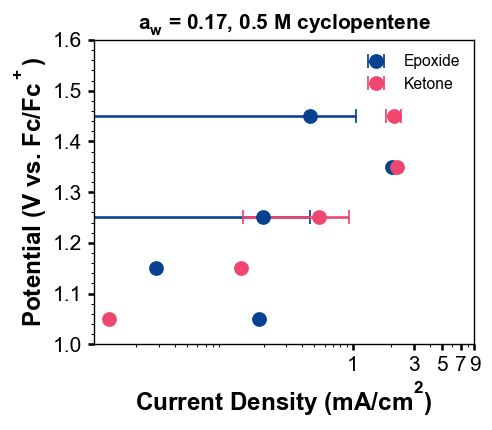

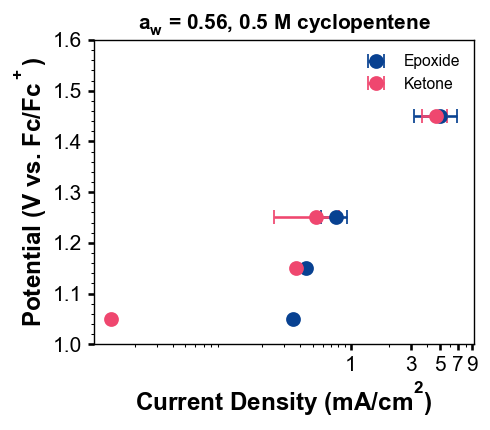

In [166]:
ax = plot_potential(df_init, 0.17, 0.5)
plot_potential(df_init, 0.56, 0.5)

# CV

In [96]:
def importBiologicMPT(fname, header=0):
    df = pd.read_csv(fname, header=0, skiprows=header, sep='\t',  usecols=lambda x: x != "Unnamed: 15",
                     encoding="iso-8859-2").rename(columns={'<I>/mA': 'I', 'Ewe/V': 'E'})
    return df

def process_mpt(df, cyclenumber, refV=0): 
    df['E'] = df['E'] + refV
    df_cycle_indices = [i for i in range(len(df['cycle number'])) if df['cycle number'][i] == cyclenumber]
    df['E']=df['E'][df_cycle_indices]
    df['I']=df['I'][df_cycle_indices]
    df = df.dropna()
    return df

In [156]:
df1 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_336_MnOx_1MH2O_ref3_062524_CV_05_CV_C03.txt"
    ),
    cyclenumber=2,
    refV=-0.31,
)

df2 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_343_MnOx_01cyclopentenene_1MH2O_ref3_070524_CV_06_CV_C08.mpt",
        header=60,
    ),
    cyclenumber=2,
    refV=-0.3,
)
df3 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_344_MnOx_05cyclopentenene_1MH2O_ref3_070524_CV_06_CV_C03.mpt",
        header=56,
    ),
    cyclenumber=2,
    refV=-0.33,
)
df3_2 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_362_MnOx_05cyclopentene_1MH2O_ref7_071024_CV_06_CV_C08.mpt",
        header=63,
    ),
    cyclenumber=2,
    refV=-0.33,
)

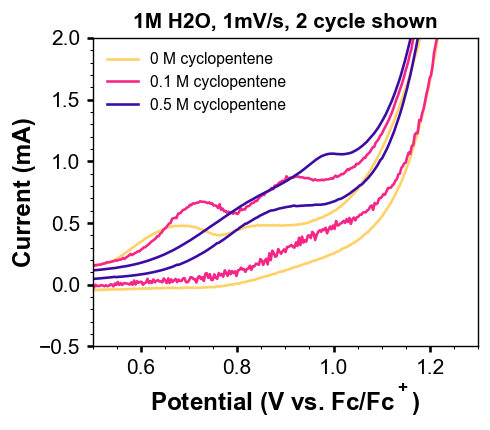

In [164]:
#plotting the cv data for the three different cyclopentene concentration 
fig, ax = plt.subplots()
ax.plot(df1["E"], df1["I"]/0.5, label="0 M cyclopentene", c=c_1)
ax.plot(df2["E"], df2["I"]/0.5, label="0.1 M cyclopentene", c=c_2)
#ax.plot(df3["E"], df3["I"], label="0.5 M cyclopentene", c=c_3)
ax.plot(df3_2["E"], df3_2["I"]/1.5, label="0.5 M cyclopentene", c=c_4)
ax.set_xlabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
ax.set_ylabel("Current (mA)", fontweight="bold")
ax.set_title("1M H2O, 1mV/s, 2 cycle shown")
ax.legend(loc="upper left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_box_aspect(0.8)
ax.set_xlim(0.5,1.3)
ax.set_ylim(-0.5, 2)
plt.tight_layout()


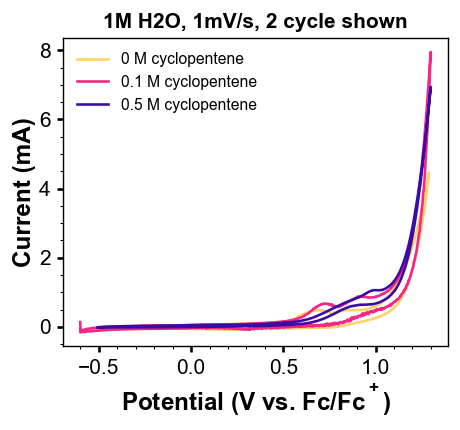

In [119]:
#plotting the cv data for the three different cyclopentene concentration 
fig, ax = plt.subplots()
ax.plot(df1["E"], df1["I"]/0.5, label="0 M cyclopentene", c=c_1)
ax.plot(df2["E"], df2["I"]/0.5, label="0.1 M cyclopentene", c=c_2)
#ax.plot(df3["E"], df3["I"], label="0.5 M cyclopentene", c=c_3)
ax.plot(df3_2["E"], df3_2["I"]/1.5, label="0.5 M cyclopentene", c=c_4)
ax.set_xlabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
ax.set_ylabel("Current (mA)", fontweight="bold")
ax.set_title("1M H2O, 1mV/s, 2 cycle shown")
ax.legend(loc="upper left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_box_aspect(0.8)
#ax.set_xlim(0.5,1.3)
#ax.set_ylim(-0.5, 2)
plt.tight_layout()

In [135]:
df4 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_350_MnOx_10MH2O_ref7_070724_CV_06_CV_C04.mpt",
        header=62,
    ),
    cyclenumber=2,
    refV=-0.27,
)

df4_2= process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_363-2_MnOx_10MH2O_ref3_071024_CV_06_CV_C03.mpt",
        header=56,
    ),
    cyclenumber=1,
    refV=-0.32,
)

df5 = process_mpt(
    importBiologicMPT(
        "/Users/chenyujiang/Python/CV/CJ_OO_364_MnOx_01cyclopentene_10MH2O_ref4_071024_06_CV_C04.mpt",
        header=59,
    ),
    cyclenumber=1,
    refV=-0.3,
)

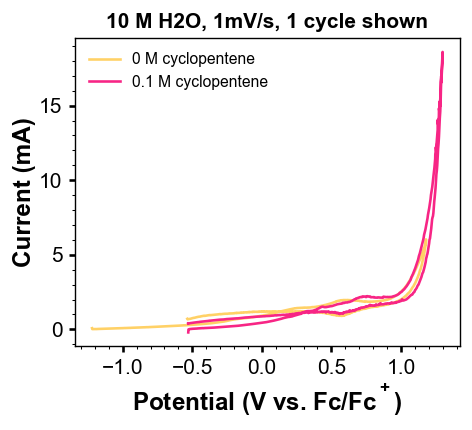

In [137]:
fig = plt.figure()
ax = fig.gca()
ax.plot(df4_2['E'], df4_2['I'], label='0 M cyclopentene', c=c_1)
ax.plot(df5['E'], df5['I'], label='0.1 M cyclopentene', c=c_2)
#ax.plot(df6['E'], df6['I'], label='0.5 M cyclopentene, 10 M H2O', c=c_4, alpha = 0.5)

ax.set_xlabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
ax.set_ylabel("Current (mA)", fontweight="bold")
ax.set_title("10 M H2O, 1mV/s, 1 cycle shown")
ax.legend(loc="upper left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_box_aspect(0.8)
plt.tight_layout()
plt.show()

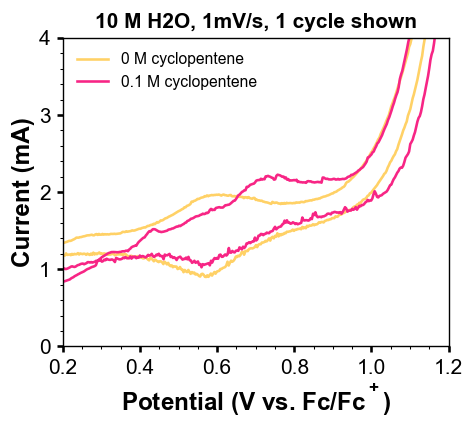

In [162]:
fig = plt.figure()
ax = fig.gca()
ax.plot(df4_2['E'], df4_2['I'], label='0 M cyclopentene', c=c_1)
ax.plot(df5['E'], df5['I'], label='0.1 M cyclopentene', c=c_2)
#ax.plot(df6['E'], df6['I'], label='0.5 M cyclopentene, 10 M H2O', c=c_4, alpha = 0.5)

ax.set_xlabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
ax.set_ylabel("Current (mA)", fontweight="bold")
ax.set_title("10 M H2O, 1mV/s, 1 cycle shown")
ax.legend(loc="upper left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_box_aspect(0.8)
ax.set_xlim(0.2,1.2)
ax.set_ylim(0, 4)
plt.tight_layout()
plt.show()

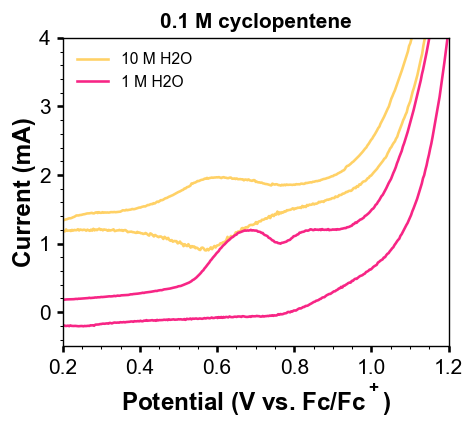

In [167]:
fig = plt.figure()
ax = fig.gca()
ax.plot(df4_2['E'], df4_2['I'], label='10 M H2O', c=c_1)
ax.plot(df1['E'], df1['I']/0.2, label='1 M H2O', c=c_2)
#ax.plot(df6['E'], df6['I'], label='0.5 M cyclopentene, 10 M H2O', c=c_4, alpha = 0.5)

ax.set_xlabel("Potential (V vs. Fc/Fc$^+$)", fontweight="bold")
ax.set_ylabel("Current (mA)", fontweight="bold")
ax.set_title("0.1 M cyclopentene")
ax.legend(loc="upper left")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_box_aspect(0.8)
ax.set_xlim(0.2,1.2)
ax.set_ylim(-0.5, 4)
plt.tight_layout()
plt.show()